import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
# I. Condorcet's Jury Theorem (1785)

Assume voter probability be correct as $p>.5$.

1. Plot the probability a jury of $n$ voters (odd) is correct as a function of $p$ for different $n$ using Monte-Carlo simulations (sampling and averaging)

2. Prove that as number of jury members grows, $n\rightarrow\infty$, the  jury majority becomes correct  $\Pr(\text{correct}) \rightarrow 1$ (**hint**: use the law of large numbers)

In [1]:
import numpy as np

In [3]:
ps = np.linspace(0.5, 1, num=50)
ns = [1, 5, 11, 51, 101, 501]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

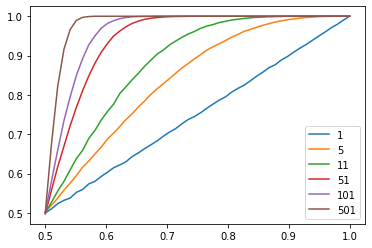

In [4]:
samples = 100000
for n in ns:
    k = int(n/2)
    jury_probs = []
    for p in ps:
        jury_probs.append(np.sum(np.random.binomial(n, p, size=samples) > k)/samples)
    plt.plot(ps, jury_probs)
plt.legend(ns)
plt.show();

# II. AdaBoost From Scratch


*   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).
*   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` with the default parameters). 
    - Split the sample set into train and test sets.
    - Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?


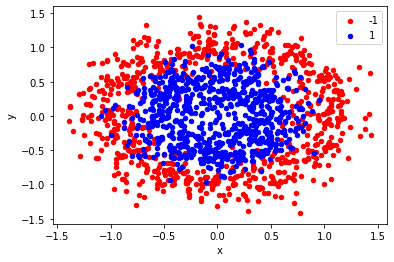

In [8]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)
y[y==0] = -1
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {-1:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [11]:
class AdaBoostSVC():
    """Boosting method that uses a number of weak classifiers in 
    ensemble to make a strong classifier. This implementation uses LinearSVC. 
    Parameters:
    -----------
    n_clf: int
        The number of weak classifiers that will be used. 
    """
    def __init__(self, n_clf=5):
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = np.shape(X)

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))
        
        self.clfs = []
        # Iterate through classifiers
        for i in range(self.n_clf):
            clf = LinearSVC()
            clf.fit(X, y)
            prediction = clf.predict(X)
            # Error = sum of weights of misclassified samples
            error = sum(w[y != prediction])
            # If the error is over 50% we flip the polarity so that samples that
            # were classified as 0 are classified as 1, and vice versa
            # E.g error = 0.8 => (1 - error) = 0.2
            if error > 0.5:
                error = 1 - error
            # Calculate the alpha which is used to update the sample weights,
            # Alpha is also an approximation of this classifier's proficiency
            alpha = 0.5 * np.log((1.0 - error) / (error + 1e-10))
            # Label 0 class predictions as '-1'
            prediction[prediction == 0] = -1
            # Calculate new weights 
            # Missclassified samples gets larger weights and correctly classified samples smaller
            w *= np.exp(-alpha * y * prediction)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append({'clf': clf, 'alpha': alpha})
        
    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        # For each classifier => label the samples
        for clf in self.clfs:
            predictions = clf['clf'].predict(X).reshape(n_samples, 1)
            predictions[predictions == 0] = -1
            # Add predictions weighted by the classifiers alpha
            # (alpha indicative of classifier's proficiency)
            y_pred += clf['alpha'] * predictions

        # Return sign of prediction sum
        y_pred = np.sign(y_pred).flatten()

        return y_pred

class DecisionStump():
    def __init__(self):
        # Determines if sample shall be classified as -1 or 1 given threshold
        self.polarity = 1
        # The index of the feature used to make classification
        self.feature_index = None
        # The threshold value that the feature should be measured against
        self.threshold = None
        # Value indicative of the classifier's accuracy
        self.alpha = None

class AdaBoostDT():
    """Boosting method that uses a number of weak classifiers in 
    ensemble to make a strong classifier. This implementation uses decision
    stumps, which is a one level Decision Tree. 
    Parameters:
    -----------
    n_clf: int
        The number of weak classifiers that will be used. 
    """
    def __init__(self, n_clf=5):
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = np.shape(X)

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))
        
        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()
            # Minimum error given for using a certain feature value threshold
            # for predicting sample label
            min_error = float('inf')
            # Iterate throught every unique feature value and see what value
            # makes the best threshold for predicting y
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)
                # Try every unique feature value as threshold
                for threshold in unique_values:
                    p = 1
                    # Set all predictions to '1' initially
                    prediction = np.ones(np.shape(y))
                    # Label the samples whose values are below threshold as '-1'
                    prediction[X[:, feature_i] < threshold] = -1
                    # Error = sum of weights of misclassified samples
                    error = sum(w[y != prediction])
                    
                    # If the error is over 50% we flip the polarity so that samples that
                    # were classified as 0 are classified as 1, and vice versa
                    # E.g error = 0.8 => (1 - error) = 0.2
                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # If this threshold resulted in the smallest error we save the
                    # configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_index = feature_i
                        min_error = error
            # Calculate the alpha which is used to update the sample weights,
            # Alpha is also an approximation of this classifier's proficiency
            clf.alpha = 0.5 * np.log((1.0 - min_error) / (min_error + 1e-10))
            # Set all predictions to '1' initially
            predictions = np.ones(np.shape(y))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Calculate new weights 
            # Missclassified samples gets larger weights and correctly classified samples smaller
            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        # For each classifier => label the samples
        for clf in self.clfs:
            # Set all predictions to '1' initially
            predictions = np.ones(np.shape(y_pred))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Add predictions weighted by the classifiers alpha
            # (alpha indicative of classifier's proficiency)
            y_pred += clf.alpha * predictions

        # Return sign of prediction sum
        y_pred = np.sign(y_pred).flatten()

        return y_pred

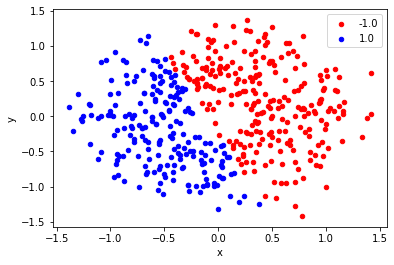

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3)
clf = AdaBoostSVC(n_clf=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
colors = {-1:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show();

It wasn't clear how to make an AdaBoost classifier that relied on LinearSVC for the weak classifier. You can see from the results above that the final classifier fails brilliantly at creating a non-linear decision boundary. The questions asked in Slack on how to make it work weren't answered, so we implemented AdaBoost using a shallow decision tree for the weak classifier that worked much better. See below.

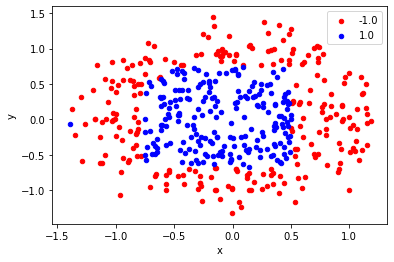

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3)
clf = AdaboostDT(n_clf=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
colors = {-1:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show();

# III. Boosting Trees from Scratch
* Use the scikit-learn's DecisionTreeRegressor with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
* Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
* Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
* **Optional**: add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
X, y = load_boston(return_X_y=True)

In [46]:
class l2boost():
    def __init__(self, n_trees=10, alpha=0.01):
        self.n_trees = int(n_trees)
        self.alpha = alpha
    
    def fit(self, X, y):
        self.trees = []
        self.mean = np.mean(y)
        residual = y - self.mean
        for i in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=1)
            tree.fit(X, residual)
            pred = tree.predict(X)
            residual -= self.alpha * pred
            self.trees.append(tree)
    
    def predict(self, X):
        n = X.shape[0]
        y_pred = np.zeros((n, 1)) + self.mean
        for tree in self.trees:
            pred = self.alpha * tree.predict(X).reshape(n, 1)
            y_pred += pred
        return y_pred

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

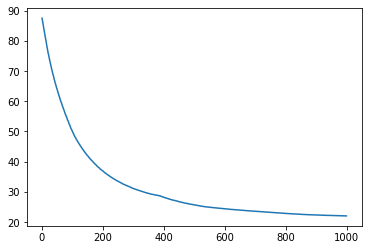

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3)
mses = []
ns = np.arange(1, 1000)
for n in ns:
    clf = l2boost(n_trees=n)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mses.append(mean_squared_error(y_test, y_pred))
plt.plot(ns, mses)
plt.show();